A robotic arm has two links with L_1=1.2 m, and L_2=0.8 m. The end effector needs to move from point A [-1.2, 0.9] to B [1.1, 0.8].
Now there is a via point C [0, 1.3] and it is required to get there by 1 s with angular velocity of -1 rad/s in both $\theta_1$ and $\theta_2$. The whole process takes 2 seconds. Please plot the result and show the animation

A 角度: [111.04  84.92] deg
C 角度: [ 52.95 101.72] deg
B 角度: [ 0.3  96.88] deg
-2.04179818487286
-0.7566092864509164
1.8796185115879123
1.746594891331581

--- 约束检查 ---
J1 Max Speed: 1.352 rad/s (Limit: 1.5)
J1 Max Accel: 4.084 rad/s^2 (Limit: 3.0)
J2 Max Speed: 1.000 rad/s (Limit: 1.5)
J2 Max Accel: 5.712 rad/s^2 (Limit: 3.0)



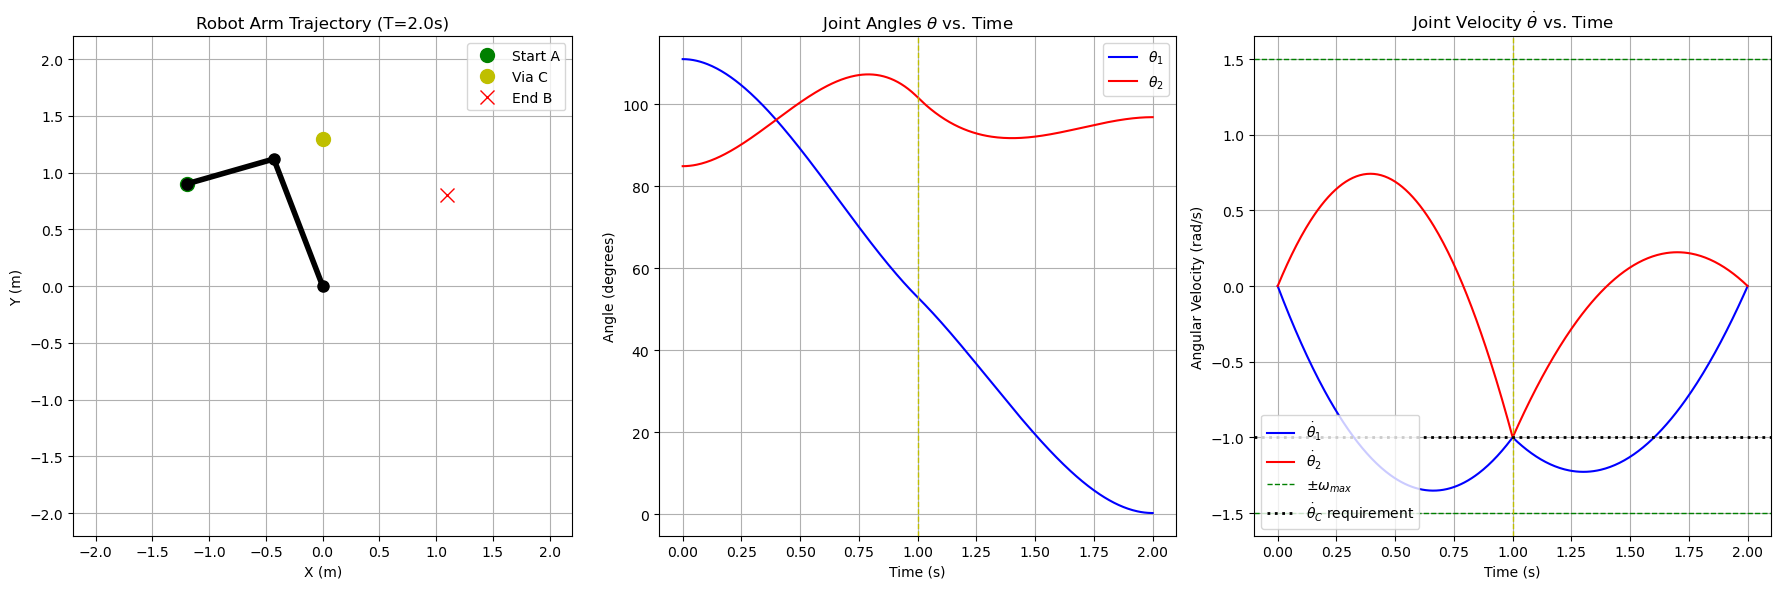

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parameters
L1 = 1.2  # 链路1长度
L2 = 0.8  # 链路2长度

# 运动学约束
ALPHA_MAX = 3.0  # 最大加速度 (rad/s^2)
OMEGA_MAX = 1.5  # 最大速度 (rad/s)

# Start, via, end points
A_cartesian = np.array([-1.2, 0.9])
C_cartesian = np.array([0.0, 1.3])
B_cartesian = np.array([1.1, 0.8])

# Time boundary
T_AC = 1.0  # A to C 时间
T_CB = 1.0  # C to B 时间
T_TOTAL = T_AC + T_CB

# Velocity boundary conditions
omega_A = 0.0
omega_C = -1.0 # 两个关节都是 -1 rad/s
omega_B = 0.0

# 时间分辨率
dt = 0.005 

# --- 2. 逆运动学函数 (与前次相同) ---

def inverse_kinematics(x, y, L1, L2, start_theta=None):
    r_sq = x**2 + y**2
    r = np.sqrt(r_sq)

    if r > (L1 + L2 + 1e-6) or r < abs(L1 - L2 - 1e-6):
        print(f"Error: Point ({x}, {y}) is unreachable.")
        return None

    cos_theta2 = (r_sq - L1**2 - L2**2) / (2 * L1 * L2)
    cos_theta2 = np.clip(cos_theta2, -1.0, 1.0)
    
    sin_theta2_pos = np.sqrt(1 - cos_theta2**2)
    
    theta2_1 = np.arctan2(sin_theta2_pos, cos_theta2)
    theta2_2 = np.arctan2(-sin_theta2_pos, cos_theta2)

    gamma = np.arctan2(y, x)
    alpha1 = np.arctan2(L2 * np.sin(theta2_1), L1 + L2 * np.cos(theta2_1))
    alpha2 = np.arctan2(L2 * np.sin(theta2_2), L1 + L2 * np.cos(theta2_2))

    theta1_1 = gamma - alpha1
    theta1_2 = gamma - alpha2

    def normalize_angle(angle):
        return (angle + np.pi) % (2 * np.pi) - np.pi

    sol1 = np.array([normalize_angle(theta1_1), normalize_angle(theta2_1)])
    sol2 = np.array([normalize_angle(theta1_2), normalize_angle(theta2_2)])

    # 选择最优解：对于 A 点，选择 theta1 较小的；对于 C 和 B 点，选择与前一点角度偏差最小的。
    if start_theta is None:
        return sol1 if sol1[0] < sol2[0] else sol2
    else:
        delta1 = np.sum(np.abs(sol1 - start_theta))
        delta2 = np.sum(np.abs(sol2 - start_theta))
        return sol1 if delta1 < delta2 else sol2

# 确定 A, C, B 的关节角度
theta_A = inverse_kinematics(A_cartesian[0], A_cartesian[1], L1, L2)
theta_C = inverse_kinematics(C_cartesian[0], C_cartesian[1], L1, L2, start_theta=theta_A)
theta_B = inverse_kinematics(B_cartesian[0], B_cartesian[1], L1, L2, start_theta=theta_C)

if theta_A is None or theta_C is None or theta_B is None:
    raise Exception("One of the points is unreachable.")

print(f"A 角度: {np.degrees(theta_A).round(2)} deg")
print(f"C 角度: {np.degrees(theta_C).round(2)} deg")
print(f"B 角度: {np.degrees(theta_B).round(2)} deg")


# --- 3. 三次多项式轨迹生成函数 ---

def cubic_trajectory(q0, qf, v0, vf, T):
    """
    计算三次多项式系数 (a0, a1, a2, a3)
    q(t) = a0 + a1*t + a2*t^2 + a3*t^3
    """
    if T == 0:
        return q0, v0, 0, 0 # 如果时间为零，返回常数
        
    a0 = q0
    a1 = v0
    
    # 矩阵形式求解 a2, a3:
    # [T^2, T^3] [a2] = [qf - q0 - v0*T]
    # [2T,  3T^2][a3] = [vf - v0]
    
    A = np.array([
        [T**2, T**3],
        [2*T, 3*T**2]
    ])
    
    B = np.array([
        qf - q0 - v0 * T,
        vf - v0
    ])
    
    # 使用 NumPy 求解线性方程组
    X = np.linalg.solve(A, B)
    a2, a3 = X[0], X[1]
    
    return a0, a1, a2, a3

def generate_segment_trajectory(q0, qf, v0, vf, T, dt):
    """
    生成一段轨迹 (位置, 速度, 加速度)
    """
    a0, a1, a2, a3 = cubic_trajectory(q0, qf, v0, vf, T)
    
    time_segment = np.arange(0, T + dt, dt)
    N_steps = len(time_segment)
    
    q_traj = np.zeros(N_steps)
    v_traj = np.zeros(N_steps)
    a_traj = np.zeros(N_steps)
    
    for i, t in enumerate(time_segment):
        # 确保 t 不超过 T
        t_norm = min(t, T)
        
        q = a0 + a1 * t_norm + a2 * t_norm**2 + a3 * t_norm**3
        v = a1 + 2 * a2 * t_norm + 3 * a3 * t_norm**2
        acc = 2 * a2 + 6 * a3 * t_norm
        
        q_traj[i] = q
        v_traj[i] = v
        a_traj[i] = acc

    # 修正最后一步
    q_traj[-1] = qf
    v_traj[-1] = vf
    
    return time_segment, q_traj, v_traj, a_traj


# --- 4. 生成两段轨迹并合并 ---

# J1 - 关节 1
# 段 AC
t_AC_1, q_AC_1, v_AC_1, a_AC_1 = generate_segment_trajectory(
    theta_A[0], theta_C[0], omega_A, omega_C, T_AC, dt
)
# 段 CB
t_CB_1, q_CB_1, v_CB_1, a_CB_1 = generate_segment_trajectory(
    theta_C[0], theta_B[0], omega_C, omega_B, T_CB, dt
)

# J2 - 关节 2
# 段 AC
t_AC_2, q_AC_2, v_AC_2, a_AC_2 = generate_segment_trajectory(
    theta_A[1], theta_C[1], omega_A, omega_C, T_AC, dt
)
# 段 CB
t_CB_2, q_CB_2, v_CB_2, a_CB_2 = generate_segment_trajectory(
    theta_C[1], theta_B[1], omega_C, omega_B, T_CB, dt
)


# 合并轨迹 (注意：t_CB 段的时间需要偏移 T_AC)
time_array_AC = t_AC_1[:-1] # 移除重复的 t=T_AC
time_array_CB = t_CB_1 + T_AC

time_array = np.concatenate((time_array_AC, time_array_CB))
N_steps = len(time_array)

theta1_traj = np.concatenate((q_AC_1[:-1], q_CB_1))
omega1_traj = np.concatenate((v_AC_1[:-1], v_CB_1))
accel1_traj = np.concatenate((a_AC_1[:-1], a_CB_1))

theta2_traj = np.concatenate((q_AC_2[:-1], q_CB_2))
omega2_traj = np.concatenate((v_AC_2[:-1], v_CB_2))
accel2_traj = np.concatenate((a_AC_2[:-1], a_CB_2))

# --- 5. 约束检查 (可选但重要) ---
max_w1 = np.max(np.abs(omega1_traj))
max_a1 = np.max(np.abs(accel1_traj))
max_w2 = np.max(np.abs(omega2_traj))
max_a2 = np.max(np.abs(accel2_traj))

print("\n--- 约束检查 ---")
print(f"J1 Max Speed: {max_w1:.3f} rad/s (Limit: {OMEGA_MAX})")
print(f"J1 Max Accel: {max_a1:.3f} rad/s^2 (Limit: {ALPHA_MAX})")
print(f"J2 Max Speed: {max_w2:.3f} rad/s (Limit: {OMEGA_MAX})")
print(f"J2 Max Accel: {max_a2:.3f} rad/s^2 (Limit: {ALPHA_MAX})")

# 检查是否满足约束
if max_w1 > OMEGA_MAX or max_w2 > OMEGA_MAX or max_a1 > ALPHA_MAX or max_a2 > ALPHA_MAX:
    print("\nWARNING: Trajectory violates one or more motion constraints!")
else:
    print("\nTrajectory satisfies all constraints.")


# --- 6. 绘图和动画设置 ---

# 正运动学
def forward_kinematics(theta1, theta2, L1, L2):
    x0, y0 = 0, 0
    x1 = L1 * np.cos(theta1)
    y1 = L1 * np.sin(theta1)
    x2 = x1 + L2 * np.cos(theta1 + theta2)
    y2 = y1 + L2 * np.sin(theta1 + theta2)
    return (x0, y0, x1, y1, x2, y2)

# 设置子图布局：1行3列
fig = plt.figure(figsize=(18, 6))

# 子图 1: 动画
ax_anim = fig.add_subplot(1, 3, 1)

# 子图 2: 角度 vs 时间
ax_theta = fig.add_subplot(1, 3, 2)

# 子图 3: 速度 vs 时间
ax_omega = fig.add_subplot(1, 3, 3)


# --- 6.1 动画图设置 ---
max_range = L1 + L2 + 0.2
ax_anim.set_xlim([-max_range, max_range])
ax_anim.set_ylim([-max_range, max_range])
ax_anim.set_aspect('equal', adjustable='box')
ax_anim.set_title(f"Robot Arm Trajectory (T={T_TOTAL:.1f}s)")
ax_anim.set_xlabel("X (m)")
ax_anim.set_ylabel("Y (m)")
ax_anim.grid(True)

# 绘制起点、终点和中途点
ax_anim.plot(A_cartesian[0], A_cartesian[1], 'go', markersize=10, label='Start A')
ax_anim.plot(C_cartesian[0], C_cartesian[1], 'yo', markersize=10, label='Via C')
ax_anim.plot(B_cartesian[0], B_cartesian[1], 'rx', markersize=10, label='End B')
ax_anim.legend()

# 初始状态
x0, y0, x1_init, y1_init, x2_init, y2_init = forward_kinematics(theta1_traj[0], theta2_traj[0], L1, L2)
line, = ax_anim.plot([x0, x1_init, x2_init], [y0, y1_init, y2_init], 'k-', lw=4, marker='o', markersize=8)
path, = ax_anim.plot([], [], 'c--', alpha=0.5, label='End Effector Path')

# --- 6.2 角度和速度图设置 ---

# 角度图
ax_theta.plot(time_array, np.degrees(theta1_traj), label=r'$\theta_1$', color='b')
ax_theta.plot(time_array, np.degrees(theta2_traj), label=r'$\theta_2$', color='r')
ax_theta.set_xlabel("Time (s)")
ax_theta.set_ylabel("Angle (degrees)")
ax_theta.set_title(r"Joint Angles $\theta$ vs. Time")
ax_theta.grid(True)
ax_theta.legend()
ax_theta.axvline(T_AC, color='y', linestyle='--', linewidth=1, label="Via Point C")

# 速度图
ax_omega.plot(time_array, omega1_traj, label=r'$\dot{\theta}_1$', color='b')
ax_omega.plot(time_array, omega2_traj, label=r'$\dot{\theta}_2$', color='r')
ax_omega.axhline(OMEGA_MAX, color='g', linestyle='--', linewidth=1)
ax_omega.axhline(-OMEGA_MAX, color='g', linestyle='--', linewidth=1, label=r'$\pm \omega_{max}$')
ax_omega.axvline(T_AC, color='y', linestyle='--', linewidth=1)
ax_omega.axhline(omega_C, color='k', linestyle=':', linewidth=2, label=r'$\dot{\theta}_C$ requirement')

ax_omega.set_xlabel("Time (s)")
ax_omega.set_ylabel("Angular Velocity (rad/s)")
ax_omega.set_title(r"Joint Velocity $\dot{\theta}$ vs. Time")
ax_omega.grid(True)
ax_omega.legend(loc='lower left')


# --- 7. 动画函数 ---

def animate(i):
    t1 = theta1_traj[i]
    t2 = theta2_traj[i]
    
    # 正运动学
    x0, y0, x1, y1, x2, y2 = forward_kinematics(t1, t2, L1, L2)
    
    # 更新机械臂
    line.set_data([x0, x1, x2], [y0, y1, y2])
    
    # 更新路径
    # 路径只记录末端执行器的位置
    current_path_x = [forward_kinematics(theta1_traj[j], theta2_traj[j], L1, L2)[4] for j in range(i + 1)]
    current_path_y = [forward_kinematics(theta1_traj[j], theta2_traj[j], L1, L2)[5] for j in range(i + 1)]
    path.set_data(current_path_x, current_path_y)
    
    return line, path

# 创建动画
frame_rate = 1.0 / dt
interval_ms = dt * 1000

ani = animation.FuncAnimation(
    fig, animate, frames=N_steps, interval=interval_ms, blit=True
)

plt.tight_layout()
plt.show()
